In [138]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

matplotlib.rcParams["pdf.fonttype"] = 42
matplotlib.rcParams["ps.fonttype"] = 42

/var/folders/ck/2h92ww3n7f934h0f58607dljk8_14b/T/ipykernel_77009/854717493.py:15: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("GnBu_r", bs_n + 4)
/var/folders/ck/2h92ww3n7f934h0f58607dljk8_14b/T/ipykernel_77009/854717493.py:17: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("OrRd_r", bs_n + 4)


168


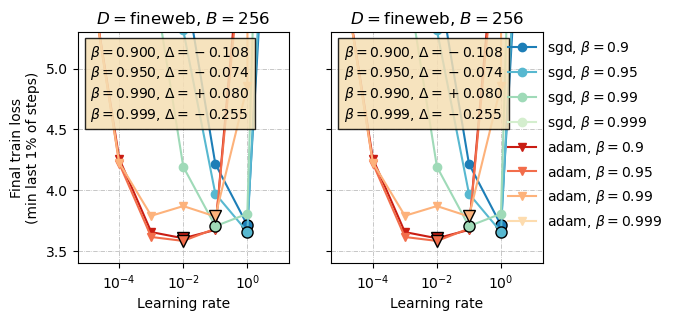

In [184]:
# data = "tinystories_ep10"
# data = "tinystories"
data = "fineweb"
metric = "tr_loss_min"
# metric = "vl_loss"
window = 0.01  # percentage of the total steps

bss = [64, 256, 1024]
bss = [256, 256]
bs_n = len(bss)
betas = [0.9, 0.95, 0.99, 0.999]
beta_n = len(betas)

colors = []
cmap = plt.cm.get_cmap("GnBu_r", bs_n + 4)
colors.append([cmap(i + 1) for i in range(beta_n)])
cmap = plt.cm.get_cmap("OrRd_r", bs_n + 4)
colors.append([cmap(i + 1) for i in range(beta_n)])

metric2text = {
    "tr_loss_min": f"Final train loss\n(min last {window:.0%} of steps)",
    "tr_loss_avg": f"Final train loss\n(avg last {window:.0%} of steps)",
    "tr_loss": "Final train loss",
    "vl_loss": "Final val loss",
    "vl_acc": "Final val acc",
}

df = pd.read_csv(f"_results/gap_{data}.csv")
df = df[df["data"] == data.split("_")[0]]
df["tr_loss_history"] = df["tr_loss_history"].apply(eval)
df["tr_loss_min"] = df["tr_loss_history"].apply(lambda x: np.min(x[-int(window*len(x)):]))  # fmt: skip
df["tr_loss_avg"] = df["tr_loss_history"].apply(lambda x: np.mean(x[-int(window*len(x)):]))  # fmt: skip
print(len(df))

fig, axes = plt.subplots(1, bs_n, figsize=(3.0 * bs_n, 3.0), sharey=True)
markers = ["o", "v", "D", "X", "^", "s", "p"]

for i, bs in enumerate(bss):
    deltas = []
    for j, beta in enumerate(betas):
        subset = df[df["mom"] == beta]
        subset = subset[subset["bs"] == bs]
        sgd = subset[subset["opt"] == "sgd"].sort_values("lr")
        adam = subset[subset["opt"] == "adam"].sort_values("lr")

        axes[i].plot(
            sgd["lr"],
            sgd[metric],
            color=colors[0][j],
            marker=markers[0],
            label=f"sgd, $\\beta={beta}$",
        )
        axes[i].plot(
            adam["lr"],
            adam[metric],
            color=colors[1][j],
            marker=markers[1],
            label=f"adam, $\\beta={beta}$",
        )

        # outline the minimum marker
        x_min_sgd = (sgd.loc[sgd[metric].idxmin(), "lr"],)
        y_min_sgd = (sgd.loc[sgd[metric].idxmin(), metric],)
        axes[i].plot(
            x_min_sgd,
            y_min_sgd,
            marker=markers[0],
            color=colors[0][j],
            markeredgecolor="black",
            markersize=8,
        )
        x_min_adam = (adam.loc[adam[metric].idxmin(), "lr"],)
        y_min_adam = (adam.loc[adam[metric].idxmin(), metric],)
        axes[i].plot(
            x_min_adam,
            y_min_adam,
            marker=markers[1],
            color=colors[1][j],
            markeredgecolor="black",
            markersize=8,
        )
        delta = y_min_adam[0] - y_min_sgd[0]
        deltas.append(delta)
    delta_text = f"$\\beta={betas[0]:.3f}$, $\\Delta={deltas[0]:+.3f}$\n"
    delta_text += f"$\\beta={betas[1]:.3f}$, $\\Delta={deltas[1]:+.3f}$\n"
    delta_text += f"$\\beta={betas[2]:.3f}$, $\\Delta={deltas[2]:+.3f}$\n"
    delta_text += f"$\\beta={betas[3]:.3f}$, $\\Delta={deltas[3]:+.3f}$"
    axes[i].text(
        0.06,
        0.95,
        delta_text,
        transform=axes[i].transAxes,
        verticalalignment="top",
        horizontalalignment="left",
        bbox=dict(facecolor="wheat", alpha=0.85),
    )

    axes[i].set_title(f"$D=${data.split('_')[0]}, $B={bs}$")
    axes[i].set_xscale("log")
    axes[i].set_xlabel("Learning rate")
    axes[i].grid(True, ls="-.", lw=0.5)
    axes[i].yaxis.set_major_locator(plt.MaxNLocator(nbins=4))
    if "tr_loss" in metric and data == "tinystories":
        axes[i].set_ylim(-0.2, 2.8)
    elif metric == "vl_loss" and data == "tinystories":
        axes[i].set_ylim(1.5, 15.2)
    elif "tr_loss" in metric and data == "tinystories_ep10":
        axes[i].set_ylim(0.5, 8.8)
    elif "vl_loss" in metric and data == "tinystories_ep10":
        axes[i].set_ylim(0.5, 8.8)
    elif "fineweb" in data:
        axes[i].set_ylim(3.4, 5.3)

axes[0].set_ylabel(metric2text[metric])

# reorder labels so that sgd are on top and adam at the bottom
handles, labels = axes[0].get_legend_handles_labels()
sgd_handles = [h for h, l in zip(handles, labels) if l.startswith("sgd")]
sgd_labels = [l for l in labels if l.startswith("sgd")]
adam_handles = [h for h, l in zip(handles, labels) if l.startswith("adam")]
adam_labels = [l for l in labels if l.startswith("adam")]
fig.legend(
    sgd_handles + adam_handles,
    sgd_labels + adam_labels,
    loc="upper right",
    bbox_to_anchor=(1.12, 0.9),
    frameon=False,
)
# plt.savefig(
#     f"_figures/gap_{data}_{metric}.pdf",
#     format="pdf",
#     dpi=300,
#     bbox_inches="tight",
# )

In [ ]:
# data = "tinystories"
# data = "fineweb"
# metric = "tr_loss_min"
# window = 0.01  # percentage of the total steps
# bss = [64, 256, 1024]

# metric2text = {
#     "tr_loss_min": f"Final train loss\n(min last {window:.0%} of steps)",
#     "tr_loss_avg": f"Final train loss\n(avg last {window:.0%} of steps)",
#     "tr_loss": "Final train loss",
#     "vl_acc": "Final val acc",
# }

# df = pd.read_csv(f"_results/gap_{data}.csv")
# df = df[df["data"] == data]
# df["tr_loss_history"] = df["tr_loss_history"].apply(eval)
# df["tr_loss_min"] = df["tr_loss_history"].apply(lambda x: np.min(x[-int(window*len(x)):]))  # fmt: skip
# df["tr_loss_avg"] = df["tr_loss_history"].apply(lambda x: np.mean(x[-int(window*len(x)):]))  # fmt: skip
# beta_unique = sorted(df["mom"].dropna().unique())
# beta_n = len(beta_unique)

# fig, axes = plt.subplots(1, beta_n, figsize=(3.0 * beta_n, 3.0), sharey=True)
# markers = ["o", "v", "D", "X", "^", "s", "p"]

# colors = []
# cmap = plt.cm.get_cmap("GnBu_r", len(bss) + 4)
# colors.append([cmap(i + 1) for i in range(len(bss))])
# cmap = plt.cm.get_cmap("OrRd_r", len(bss) + 4)
# colors.append([cmap(i + 1) for i in range(len(bss))])

# for i, beta in enumerate(beta_unique):
#     deltas = []
#     for j, bs in enumerate(bss):
#         subset = df[df["mom"] == beta]
#         subset = subset[subset["bs"] == bs]
#         sgd = subset[subset["opt"] == "sgd"].sort_values("lr")
#         adam = subset[subset["opt"] == "adam"].sort_values("lr")

#         axes[i].plot(
#             sgd["lr"],
#             sgd[metric],
#             color=colors[0][j],
#             marker=markers[0],
#             label=f"sgd, $B={bs}$",
#         )
#         axes[i].plot(
#             adam["lr"],
#             adam[metric],
#             color=colors[1][j],
#             marker=markers[1],
#             label=f"adam, $B={bs}$",
#         )

#         # outline the minimum marker
#         x_min_sgd = (sgd.loc[sgd[metric].idxmin(), "lr"],)
#         y_min_sgd = (sgd.loc[sgd[metric].idxmin(), metric],)
#         axes[i].plot(
#             x_min_sgd,
#             y_min_sgd,
#             marker=markers[0],
#             color=colors[0][j],
#             markeredgecolor="black",
#             markersize=8,
#         )
#         x_min_adam = (adam.loc[adam[metric].idxmin(), "lr"],)
#         y_min_adam = (adam.loc[adam[metric].idxmin(), metric],)
#         axes[i].plot(
#             x_min_adam,
#             y_min_adam,
#             marker=markers[1],
#             color=colors[1][j],
#             markeredgecolor="black",
#             markersize=8,
#         )
#         delta = y_min_adam[0] - y_min_sgd[0]
#         deltas.append(delta)
#     delta_text = f"$B={bss[0]}$, $\\Delta={deltas[0]:+.3f}$\n"
#     delta_text += f"$B={bss[1]}$, $\\Delta={deltas[1]:+.3f}$\n"
#     delta_text += f"$B={bss[2]}$, $\\Delta={deltas[2]:+.3f}$"
#     axes[i].text(
#         0.06,
#         0.95,
#         delta_text,
#         transform=axes[i].transAxes,
#         verticalalignment="top",
#         horizontalalignment="left",
#         bbox=dict(facecolor="wheat", alpha=0.85),
#     )

#     axes[i].set_title(f"$D=${data}, $\\beta={beta}$")
#     axes[i].set_xscale("log")
#     axes[i].set_xlabel("Learning rate")
#     axes[i].grid(True, ls="-.", lw=0.5)
#     axes[i].yaxis.set_major_locator(plt.MaxNLocator(nbins=4))
#     if "min" in metric and data == "tinystories":
#         axes[i].set_ylim(-0.1, 4.4)
#     elif "min" in metric and data == "fineweb":
#         axes[i].set_ylim(3.4, 5.4)

# axes[0].set_ylabel(metric2text[metric])

# # reorder labels so that sgd are on top and adam at the bottom
# handles, labels = axes[0].get_legend_handles_labels()
# sgd_handles = [h for h, l in zip(handles, labels) if l.startswith("sgd")]
# sgd_labels = [l for l in labels if l.startswith("sgd")]
# adam_handles = [h for h, l in zip(handles, labels) if l.startswith("adam")]
# adam_labels = [l for l in labels if l.startswith("adam")]
# fig.legend(
#     sgd_handles + adam_handles,
#     sgd_labels + adam_labels,
#     loc="upper right",
#     bbox_to_anchor=(1.065, 0.9),
#     frameon=False,
# )
# plt.savefig(
#     f"_figures/gap_{data}_{metric}.pdf",
#     format="pdf",
#     dpi=300,
#     bbox_inches="tight",
# )

/var/folders/ck/2h92ww3n7f934h0f58607dljk8_14b/T/ipykernel_77009/1099914786.py:25: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("GnBu_r", bs_n + 4)
/var/folders/ck/2h92ww3n7f934h0f58607dljk8_14b/T/ipykernel_77009/1099914786.py:27: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("OrRd_r", bs_n + 4)


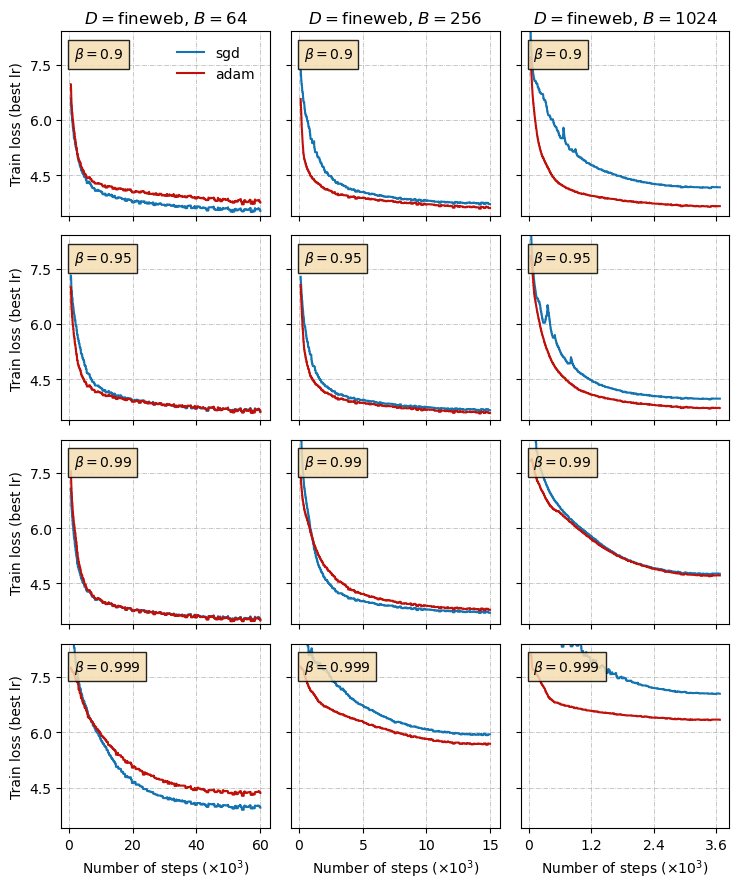

In [161]:
def smooth(y, metric, window=10):
    if metric == "tr_loss_min":
        return pd.Series(y).rolling(window).min().values
    elif metric == "tr_loss_avg":
        return pd.Series(y).rolling(window).mean().values
    else:
        raise ValueError(f"Unknown metric: {metric}")


data = "fineweb"
metric = "tr_loss_min"
window = 0.01  # percentage of the total steps

bss = [64, 256, 1024]
bs_n = len(bss)
betas = [0.9, 0.95, 0.99, 0.999]
beta_n = len(betas)

df = pd.read_csv(f"_results/gap_{data}.csv")
df = df[df["data"] == data]
df["tr_loss_history"] = df["tr_loss_history"].apply(eval)

fig, axes = plt.subplots(beta_n, bs_n, figsize=(2.5 * bs_n, 2.25 * beta_n), sharey=True)  # fmt: skip
colors = []
cmap = plt.cm.get_cmap("GnBu_r", bs_n + 4)
colors.append([cmap(i + 1) for i in range(bs_n)])
cmap = plt.cm.get_cmap("OrRd_r", bs_n + 4)
colors.append([cmap(i + 1) for i in range(bs_n)])

for row, beta in enumerate(betas):
    df_beta = df[df["mom"] == beta]
    for col, bs in enumerate(bss):
        ax = axes[row][col]
        subset = df_beta[df_beta["bs"] == bs]

        for i, opt in enumerate(["sgd", "adam"]):
            # Find the run with the smallest tr_loss in the last 1% of steps
            min_idx = subset_opt = None
            min_val = np.inf
            for idx, row_ in subset[subset["opt"] == opt].iterrows():
                history = row_["tr_loss_history"]
                window_size = max(1, int(window * len(history)))
                last_1pct = history[-window_size:]
                val = np.min(last_1pct)
                if val < min_val:
                    min_val = val
                    min_idx = idx
            best_history = subset.loc[min_idx, "tr_loss_history"]
            history_smoothed = smooth(best_history, metric, window_size)
            steps = np.arange(len(history_smoothed))
            ax.plot(steps, history_smoothed, label=opt, color=colors[i][0])

        lastr = row == beta_n - 1
        if col == 0:
            ax.set_xticks([0, 3_333, 6_666, 10_000])
            ax.set_xticklabels([r"$0$", r"$20$", r"$40$", r"$60$"] if lastr else [])
        elif col == 1:
            ax.set_xticks([0, 3_333, 6_666, 10_000])
            ax.set_xticklabels([r"$0$", r"$5$", r"$10$", r"$15$"] if lastr else [])
        elif col == 2:
            ax.set_xticks([0, 1_233, 2_466, 3_700])
            ax.set_xticklabels([r"$0$", r"$1.2$", r"$2.4$", r"$3.6$"] if lastr else [])
        if data == "tinystories":
            ax.set_ylim(-0.2, 5.8)
        elif data == "fineweb":
            ax.set_ylim(3.4, 8.4)
        ax.set_title(f"$D=${data}, $B={bs}$" if row == 0 else "")
        ax.annotate(
            f"$\\beta={beta}$",
            xy=(0.06, 0.925),
            xycoords="axes fraction",
            verticalalignment="top",
            bbox=dict(facecolor="wheat", alpha=0.85),
        )
        ax.grid(True, ls="-.", lw=0.5)
        ax.set_xlabel(r"Number of steps ($\times 10^3$)" if lastr else "")
        ax.yaxis.set_major_locator(plt.MaxNLocator(nbins=4))
    axes[row][0].set_ylabel("Train loss (best lr)")

axes[0][0].legend(loc="upper right", bbox_to_anchor=(0.99, 0.99), frameon=False)
plt.tight_layout()
plt.savefig(
    f"_figures/curve_gap_{data}_{metric}.pdf",
    format="pdf",
    dpi=300,
    bbox_inches="tight",
)